In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import math

plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use("ggplot")

In [2]:
data = pd.read_csv("data/iris.csv", names=["sepal_length", "sepal_width", "petal_length", "petal_width", "label"])
data.head(2)

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa


<AxesSubplot:xlabel='sepal_length', ylabel='sepal_width'>

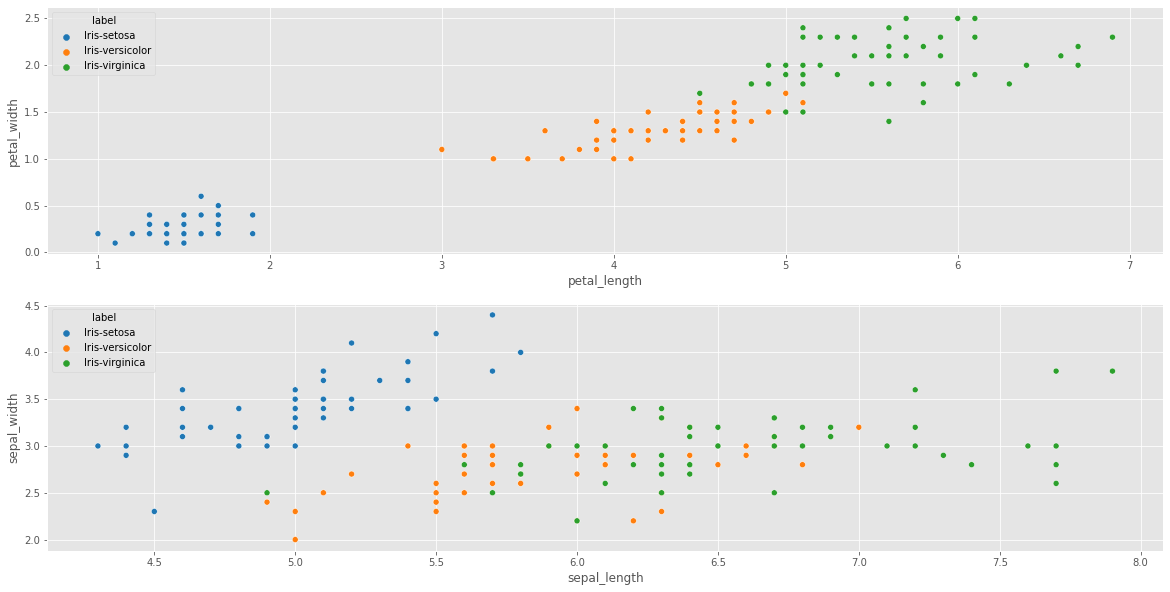

In [3]:
plt.subplot(2, 1, 1)
sns.scatterplot(data=data, x="petal_length", y="petal_width", hue="label",palette="tab10")
plt.subplot(2, 1, 2)
sns.scatterplot(data=data, x="sepal_length", y="sepal_width", hue="label", palette="tab10")

#### From the above graph we can conclude that information about the petals can help us classify iris-setosa from the order 2 classes

We will hence create a logistic regression classifier using these variables. We will also convert the labels of the other two classes to non_setosa so that our data now as only two classes.

,label,encoded_labels
0,Iris-setosa,0
50,non_setosa,1


<AxesSubplot:xlabel='petal_width', ylabel='petal_length'>

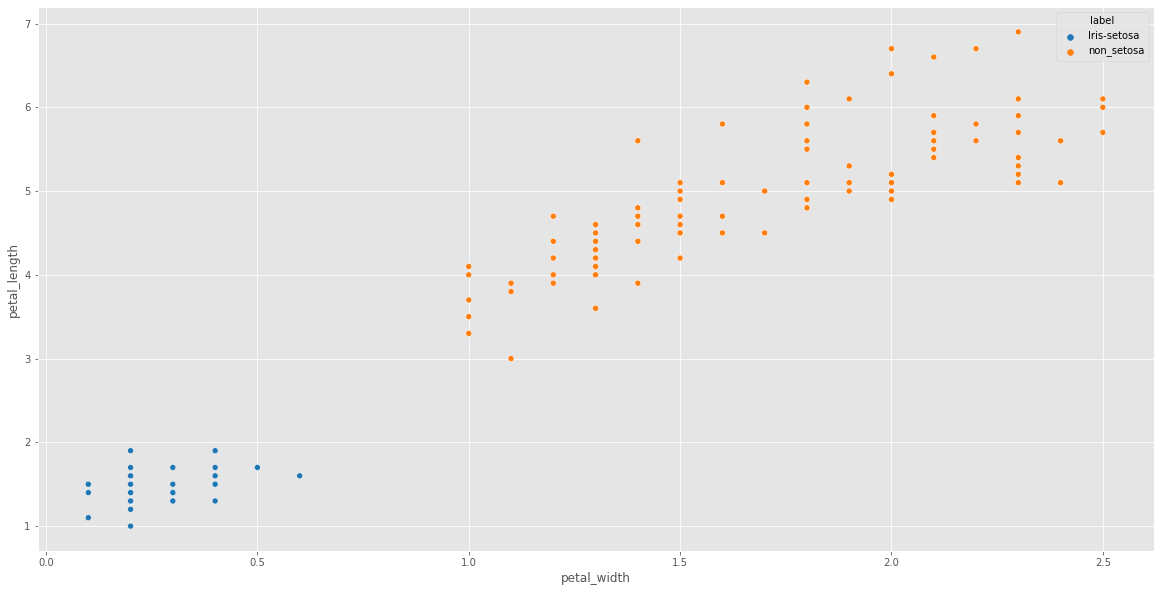

In [4]:
# Simply replace the string of the other two classes with `non_sentosa`
# We pass the `label` column to label encoder which maps the string labels to integer

augmented_data = data.copy()
augmented_data = augmented_data.replace("Iris-virginica", "non_setosa").replace("Iris-versicolor", "non_setosa")

encoder = LabelEncoder()
new_labels = encoder.fit_transform(augmented_data.label.values)
augmented_data["encoded_labels"] = new_labels
display(augmented_data[["label", "encoded_labels"]].drop_duplicates())
sns.scatterplot(data=augmented_data, x="petal_width", y="petal_length", hue="label", palette="tab10")

### Iris-sentosa is mapped to the label <span style="color:yellow">0</span> and non_setosa is mapped to <span style="color:yellow">1</span>

In [11]:
class BinaryClassLogisticRegression:

    def __init__(self, alpha=0.001):
        self.alpha = alpha
        self.w: np.array = None
        self.b = random.random()*0.1

        self.w_tracker = []
        self.b_tracker = []
        self.cost_tracker = []
        self.test_metrics = {}

    @staticmethod
    def get_sigmoid_value(eq_value):
        """
        :returns (1,n) matric
        """
        return 1 / (1 + np.exp(-eq_value))

    def get_eq_value(self, features_):
        """
        (m,1).T * (m,n) + (1,1) => (1,n) + (1,1) = (1,n)
        :returns (1,n) matrix
        """
        return self.w.T.dot(features_) + self.b

    def get_performance(self, x, y):
        """
        :param x: (m,n) matrix
        :param y: (n,1) matrix
        """
        calculated_label = self.get_sigmoid_value(self.get_eq_value(x)) # (1,n) matrix
        individual_cost = -(y * np.log(calculated_label.T) +
                            (1 - y) * np.log(1 - calculated_label.T))
        cost = individual_cost.sum() / individual_cost.shape[0]
        return calculated_label.T, cost

    def train(self, x, y):
        """
        x is currently (n,m) where n is the number of observatoins while m is the number of feature in each observation
        we transpose x to (m,n) we do this since our W matrix would be an (m,1) matrix. when we do wTx+b we will have
        (1,m)*(m,n) = (1,n) matrix to which we add the constant bias term b
        """
        x = x.T # x shape is now (m,n)
        self.w = np.random.random((x.shape[0],1))*0.1 # w shape is (m,1)
        iterations = 1
        while True:
            self.w_tracker.append(self.w)
            # self.b_tracker.append(self.b)
            calculated_labels, average_cost = self.get_performance(x,y)
            self.cost_tracker.append(average_cost)
            a_y = calculated_labels - y # (n,1) matrix
            dw = x.dot(a_y) / len(x) # (m,n).(n,1) = (m,1)
            db = sum(a_y) / len(x)
            updated_w = self.w - self.alpha * dw
            updated_b = self.b - self.alpha * db

            if iterations >= 10000:
                break
            self.w = updated_w
            self.b = updated_b
            iterations += 1

    def test(self, x, y):
        prediction_probability, cost = self.get_performance(x.T, y)
        self.test_metrics = {
            "prediction_probabilities": prediction_probability,
            "cost": prediction_probability,
            "predictions": np.round(prediction_probability).astype(int),
        }
        return self.test_metrics["predictions"]

In [16]:
features = augmented_data[["sepal_length","sepal_width"]].values
labels = augmented_data["encoded_labels"].values
x_train, x_test, y_train, y_test = train_test_split(features, labels)
y_train = y_train.reshape((y_train.shape[0],1))
y_test = y_test.reshape((y_test.shape[0],1))

In [17]:
custom_model = BinaryClassLogisticRegression()
custom_model.train(x_train, y_train)
predictions = custom_model.test(x_test, y_test)

In [18]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        27

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



<AxesSubplot:>

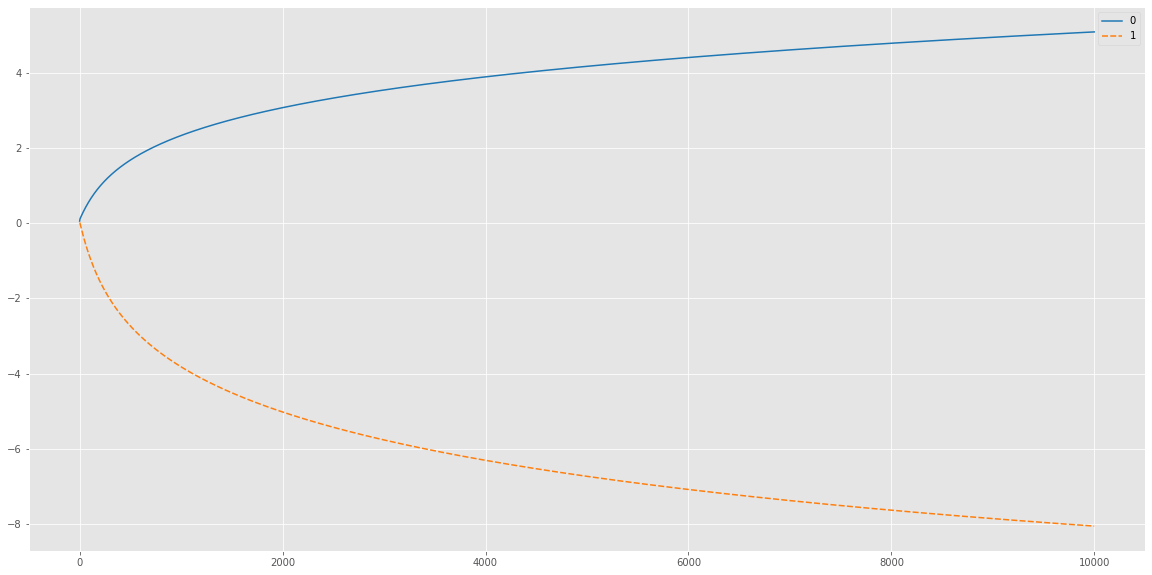

In [21]:
weights_df = pd.DataFrame([i.reshape((i.shape[0],)) for i in custom_model.w_tracker])
sns.lineplot(data=weights_df,palette="tab10")